# Train the pose 2D Regressor

## Load the dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
import scipy.misc
import hashlib
from os import listdir
from os.path import isfile, join
import os
import random
from PIL import Image
import tensorflow as tf
import os
import time
import configparser
import json
import tensorflow as tf
import tensorflow.contrib.slim as slim
from statistics import mean

In [2]:
os.chdir("../../../")

In [3]:
from src.training.pose_2d.dataProvider import DataProvider
from src.training.pose_2d.heatmapProvider import HeatmapProvider
from src.utils.drawer import Drawer 
from src.utils.pose import Pose2D
from src.utils.pose import PoseConfig
from src.utils.bbox import BBox
from src.system.pose_2d.interface import Pose2DInterface

## Adapt the data for the network

Encode (images, PoseList) provided by the data provider into (image, NetworkOutput) composed with n heatmaps followed by n offest_x and n offset_y (n the total number of joints).
Note that the data provider wrapped in the following class returns batchsize cropped images with one subject on each.

In [4]:
class DataProviderAdaptator:
    
    
    def __init__(self, annotFile, imageDir, inputSize, outputSize, batchSize):
        
        self.provider = DataProvider.build(annotFile, imageDir, inputSize, batchSize)
        self.outputSize = outputSize
        self.inputSize = inputSize
        self.batchSize = batchSize
        
    
    def decodePoses(self, outputs):
        
        poses = []
        
        totalJoints = len(PoseConfig.NAMES)
        for recordId in range(outputs.shape[0]):
            
            heatmap = outputs[recordId, :, :, :totalJoints]
            xOff = outputs[recordId, :, :, totalJoints:(totalJoints*2)]
            yOff = outputs[recordId, :, :, (totalJoints*2):]
            
            joints = np.zeros((totalJoints,2)) - 1
            
            for jointId in range(totalJoints):
                
                inlinedPix = heatmap[:,:,jointId].reshape(-1)
                pixId = np.argmax(inlinedPix)
                
                # if max confidence below 0.1 => inactive joint
                if inlinedPix[pixId]<0.01:
                    continue
                
                outX = pixId%self.outputSize[0]
                outY = pixId//self.outputSize[0]
                
                x = outX/self.outputSize[0]*self.inputSize[0] + xOff[outY, outX, jointId]
                y = outY/self.outputSize[1]*self.inputSize[1] + yOff[outY, outX, jointId]
                
                x = x/self.inputSize[0]
                y = y/self.inputSize[1]
                
                joints[jointId,0] = x
                joints[jointId,1] = y
            
            poses.append(Pose2D(joints))
            
            
        return poses

    
    def processAnnotations(self, outputs):
        
        annotations = []
        
        for pose in outputs: 
            
            joints = pose.get_joints()
            
            # clamp below one so that : id = xValue*imgSize is consistant
            joints = np.minimum(joints, 0.99999)
            
            heatmaps, xOffsets, yOffsets = [], [], []
            
            for jointId in range(len(PoseConfig.NAMES)):
                
                x, y = int(joints[jointId, 0]*self.outputSize[0]), int(joints[jointId, 1]*self.outputSize[1])

                tmp = np.zeros((1, self.outputSize[1], self.outputSize[0], 1))
                if pose.is_active_joint(jointId):
                    tmp[0,y,x,0] = 1.0
                    
                heatmaps.append(tmp)
                
                offX, offY = int(joints[jointId, 0]*self.inputSize[0]), int(joints[jointId, 1]*self.inputSize[1])
                offX, offY = offX - int((x/self.outputSize[0])*self.inputSize[0]), offY - int((y/self.outputSize[1])*self.inputSize[1])
                
                tmp = np.zeros((1, self.outputSize[1], self.outputSize[0], 1))
                if pose.is_active_joint(jointId):
                    tmp[0,y,x,0] = offX
                xOffsets.append(tmp)
                
                tmp = np.zeros((1, self.outputSize[1], self.outputSize[0], 1))
                if pose.is_active_joint(jointId):
                    tmp[0,y,x,0] = offY
                yOffsets.append(tmp)
            
            heatmaps = np.concatenate(heatmaps, 3) 
            xOffsets = np.concatenate(xOffsets, 3) 
            yOffsets = np.concatenate(yOffsets, 3) 
            annot = np.concatenate([heatmaps, xOffsets, yOffsets], 3)
            
            annotations.append(annot)
        
        annotations = np.concatenate(annotations, 0)
        
        return annotations
    
    
    def debug(self):
        
        # get inputs images + poses annot
        inputsOrig, outputsOrig = self.provider.drawn()
        
        # build encoded annotation
        inputs, outputs = inputsOrig, self.processAnnotations(outputsOrig)
        
        # decode the annotation back to a pose class
        poses = self.decodePoses(outputs)

        for recordId in range(inputs.shape[0]):
            for i in range(len(PoseConfig.NAMES)):
                isOk = outputs[recordId,:,:,i].sum() == 1

            img = (((inputs[recordId, :, :, :]+1)/2)*255).astype(np.uint8)
            
            print("encoded-decoded")
            img1 = Drawer().draw_2d_pose(img, poses[recordId])
            plt.imshow(img1)
            plt.show()
            
            print("original")
            img2 = Drawer().draw_2d_pose(img, outputsOrig[recordId])
            plt.imshow(img2)
            plt.show()
            
            
    def getBatchSize(self):
        return self.batchSize 
    
    def drawn(self):
        inputs, outputs = self.provider.drawn()
        return inputs, self.processAnnotations(outputs)
        
        

In [5]:
annotFile = "dataset/cocoapi/data/annotations/person_keypoints_train2017.json"
imageDir = "dataset/cocoapi/data/images"
inputSize = (160,160)
outputSize = (10,10)
batchSize = 32
dataTrainProvider = DataProviderAdaptator(annotFile, imageDir, inputSize, outputSize, batchSize)

TOTAL ANNOTATED EXAMPLES : 19759


In [6]:
imageDir = "dataset/cocoapi/data/images"
inputSize = (160,160)
outputSize = (10,10)
batchSize = 32
annotFile = "dataset/cocoapi/data/annotations/person_keypoints_val2017.json"
dataValProvider = DataProviderAdaptator(annotFile, imageDir, inputSize, outputSize, batchSize)

TOTAL ANNOTATED EXAMPLES : 787


encoded-decoded


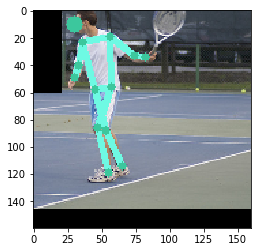

original


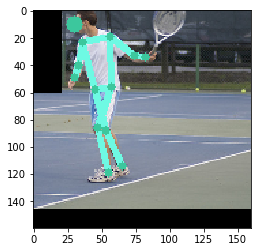

encoded-decoded


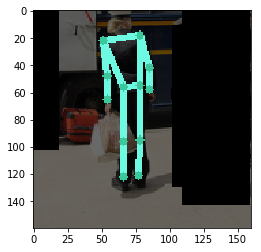

original


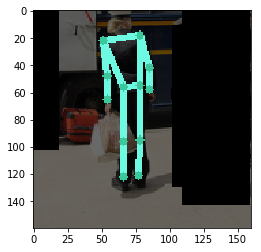

encoded-decoded


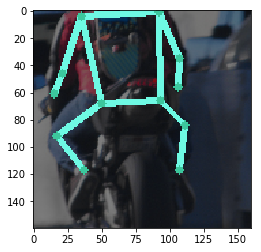

original


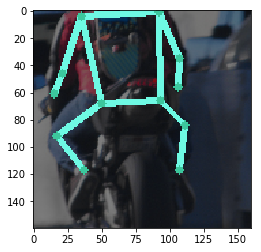

encoded-decoded


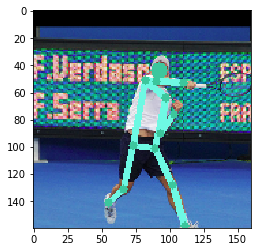

original


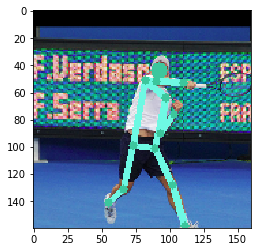

encoded-decoded


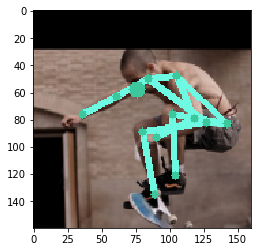

original


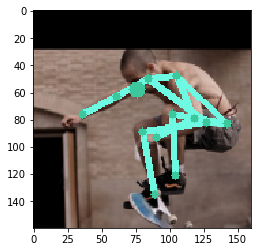

encoded-decoded


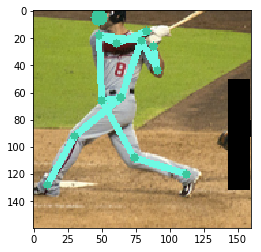

original


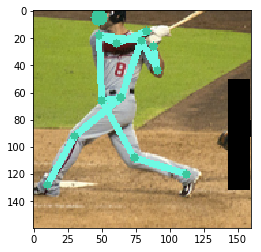

encoded-decoded


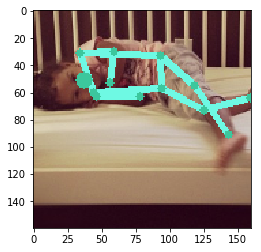

original


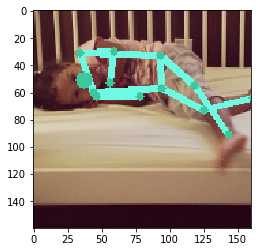

encoded-decoded


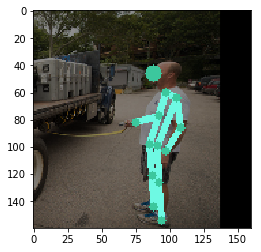

original


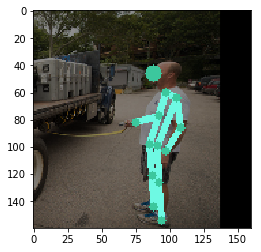

encoded-decoded


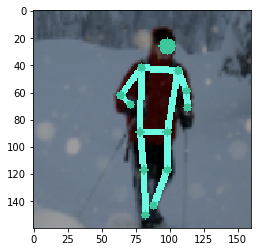

original


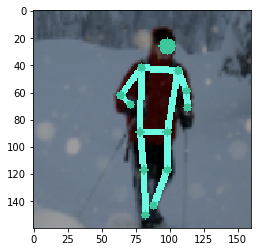

encoded-decoded


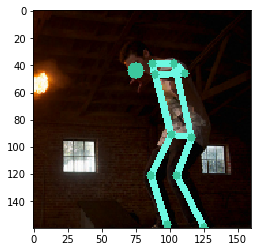

original


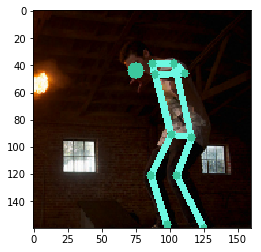

encoded-decoded


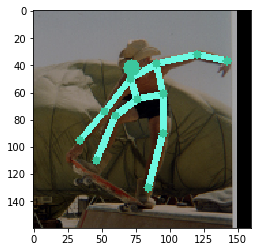

original


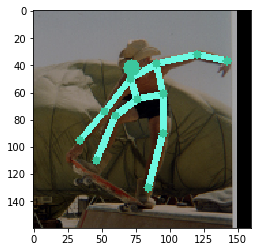

encoded-decoded


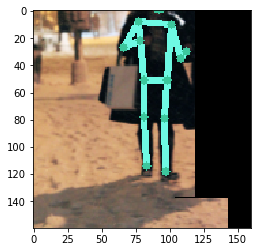

original


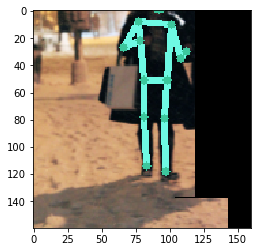

encoded-decoded


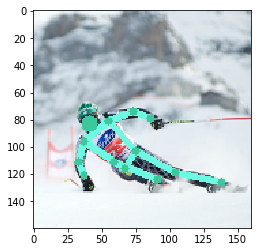

original


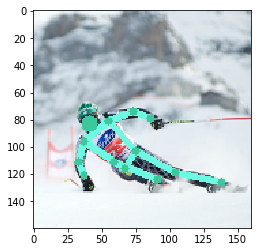

encoded-decoded


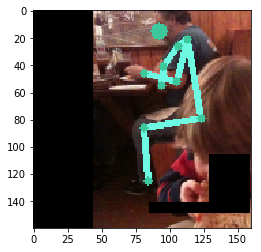

original


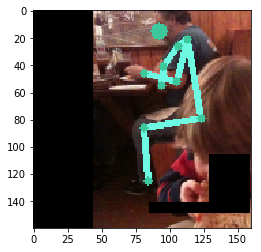

encoded-decoded


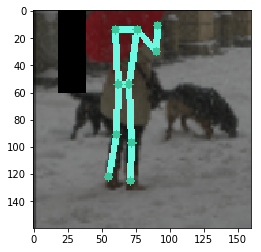

original


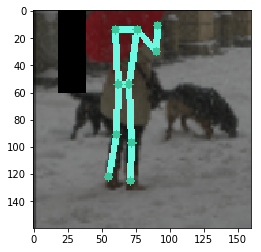

encoded-decoded


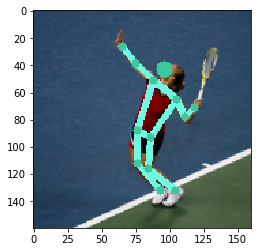

original


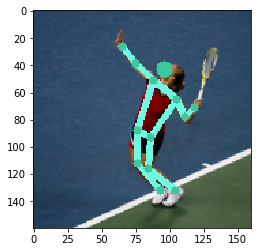

encoded-decoded


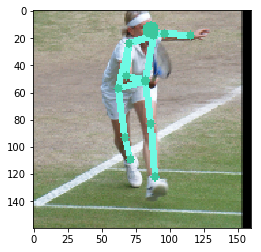

original


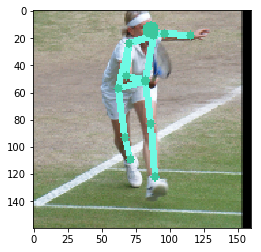

encoded-decoded


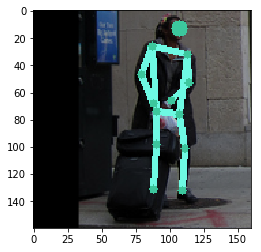

original


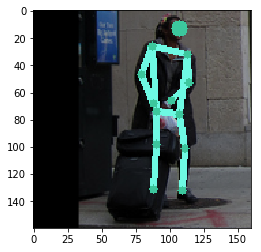

encoded-decoded


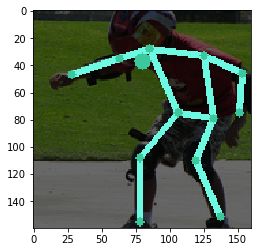

original


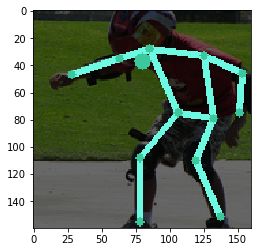

encoded-decoded


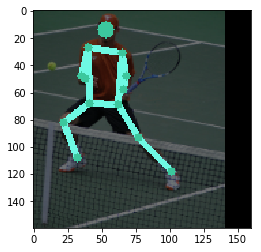

original


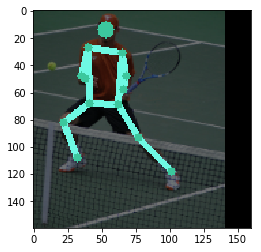

encoded-decoded


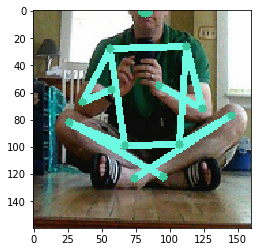

original


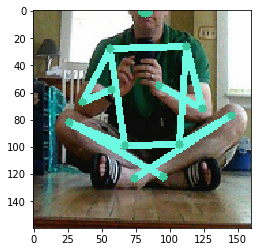

encoded-decoded


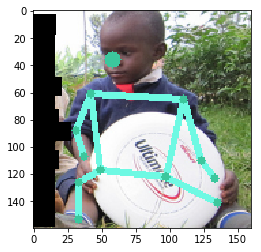

original


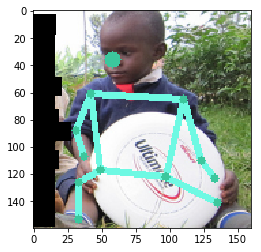

encoded-decoded


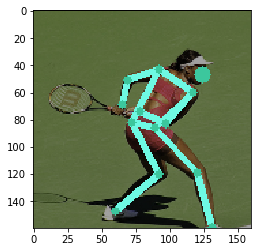

original


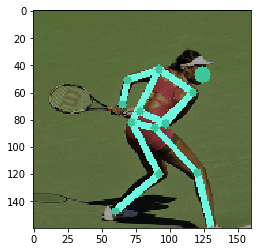

encoded-decoded


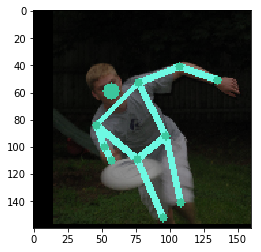

original


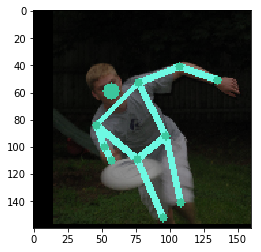

encoded-decoded


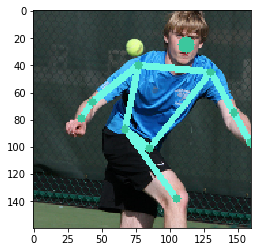

original


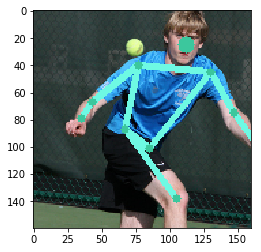

encoded-decoded


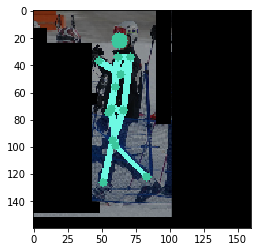

original


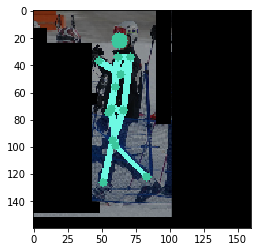

encoded-decoded


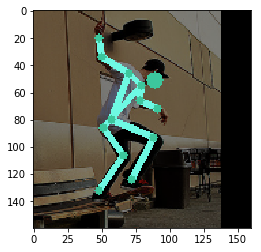

original


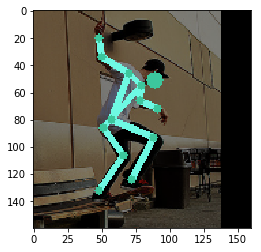

encoded-decoded


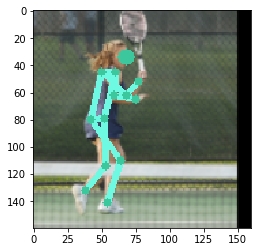

original


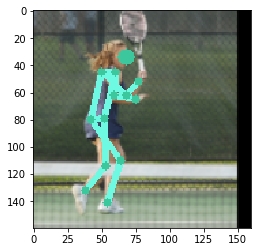

encoded-decoded


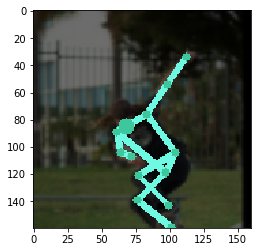

original


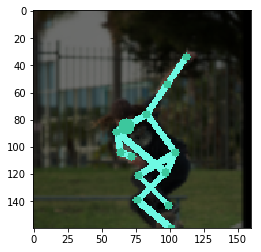

encoded-decoded


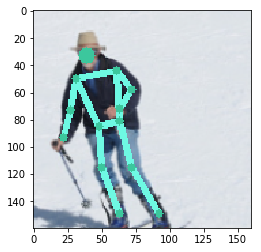

original


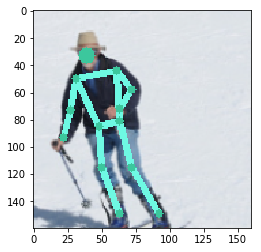

encoded-decoded


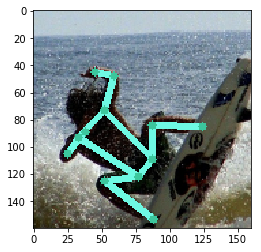

original


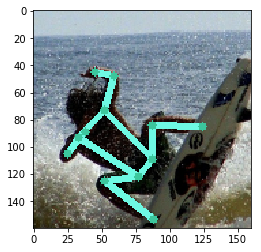

encoded-decoded


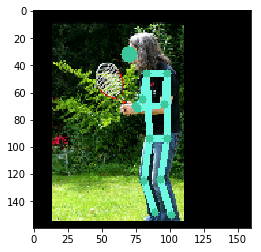

original


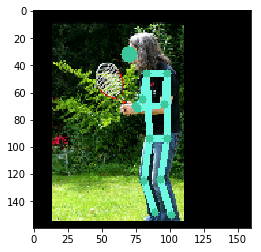

In [7]:
dataValProvider.debug()

# Class managing the training of the model 

In [8]:
class Trainer:    
    
    SAVE_EVERY = 100
    TEST_EVERY = 10
    VIZ_EVERY = 300
    
    def __init__(self, inputImage, output, outputStages, dataTrainProvider, dataValProvider, modelDir, lossFunc, inputSize=160, sess=None):
        
        self.inputSize  = 160
        self.dataTrainProvider, self.dataValProvider = dataTrainProvider, dataValProvider
        
        self.inputImage = inputImage
        self.output = output
        
        self.heatmapGT = tf.placeholder(tf.float32, shape=(None, output.shape[1], output.shape[2], 13*3), name='heatmapGT')
        self.trainLoss = self._buildLoss(self.heatmapGT, outputStages, dataTrainProvider.getBatchSize(), lossFunc, "trainLoss")
        
        self.globalStep = tf.Variable(0, trainable=False)
        
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config) if isinstance(sess, type(None)) else sess
        
        self.learningRate = tf.placeholder(tf.float32, [], name='learningRate')
        
        self.updater = self._buildUpdater(self.trainLoss, self.globalStep, self.learningRate)
        
        self.sess.run(tf.global_variables_initializer())
        
        self.saver = tf.train.Saver(max_to_keep=10)
        
        self.savePath = os.path.join(modelDir, "checkpoints")
        
        tf.summary.scalar("trainLoss", self.trainLoss)
        
        self.fileWriter = tf.summary.FileWriter( os.path.join(modelDir, "logs"), self.sess.graph)
        self.summaryMerge = tf.summary.merge_all()
        
        
    def restore(self, checkpointPath):
        tf.train.Saver().restore(self.sess, checkpointPath)
        
    def setLearningRate(self, lr):
        self.sess.run(self.learningRate, feed_dict={self.learningRate: lr})
        
        
    def _buildLoss(self, heatmapGT, outputStages, batchSize, lossFunc, lossName):
        losses = []
        for idx,stage_out in enumerate(outputStages):
            loss = lossFunc(heatmapGT, stage_out, lossName+'_'+str(idx), batchSize)
            tf.summary.scalar(lossName+"_stage_"+str(idx), ( tf.reduce_sum(loss) / batchSize ) )
            losses.append(loss)

        return ( tf.reduce_sum(losses) / len(outputStages) ) / batchSize
    
    
    @staticmethod
    def l2Loss(gt, pred, lossName, batchSize):
        return tf.nn.l2_loss(pred - gt, name=lossName)
    
    
    @staticmethod
    def posenetLoss(gt, pred, lossName, batchSize):
        
        predHeat, gtHeat = pred[:,:,:,:len(PoseConfig.NAMES)], gt[:,:,:,:len(PoseConfig.NAMES)]
        predOffX, gtOffX = pred[:,:,:,len(PoseConfig.NAMES):(2*len(PoseConfig.NAMES))], gt[:,:,:,len(PoseConfig.NAMES):(2*len(PoseConfig.NAMES))]
        predOffY, gtOffY = pred[:,:,:,(2*len(PoseConfig.NAMES)):], gt[:,:,:,(2*len(PoseConfig.NAMES)):]
        
        heatmapLoss = tf.nn.l2_loss(predHeat - gtHeat, name=lossName+"_heatmapLoss")
        
        offsetGT, offsetPred = [], []
        
        offsetLoss = 0
        
        for recordId in range(batchSize):
            for jointId in range(len(PoseConfig.NAMES)):
                
                print(str(recordId)+"/"+str(batchSize)+" : "+str(jointId))
                # ================================> decode <x,y> from gt heatmap
                
                inlinedPix = tf.reshape(gtHeat[recordId, :, :, jointId], [-1])
                pixId = tf.argmax(inlinedPix)
                
                # if joint isn't annotated (gt at 1.0 otherwise)
                #if inlinedPix[pixId].eval()<0.1:
                #    continue

                x = tf.floormod(pixId,gtHeat.shape[2])
                y = tf.cast(tf.divide(pixId,gtHeat.shape[2]), tf.int64)
                
                # ==============================> add offset loss over the gt pix
                

                offsetGT.append(gtOffX[recordId, y, x, jointId])
                offsetPred.append(predOffX[recordId, y, x, jointId])
                offsetGT.append(gtOffY[recordId, y, x, jointId])
                offsetPred.append(predOffY[recordId, y, x, jointId])
                
            
        print("start building huber loss")
        offsetGT = tf.stack(offsetGT, 0)
        offsetPred = tf.stack(offsetPred, 0)
        offsetLoss = 5*tf.losses.huber_loss(offsetGT, offsetPred)
        print("huber loss built")
        
        tf.summary.scalar(lossName+"_heatmapLoss", heatmapLoss )
        tf.summary.scalar(lossName+"_offsetLoss", offsetLoss )
        
        return (heatmapLoss + offsetLoss)
        
    
    def _buildUpdater(self, loss, globalStep, lr):
        
        tf.summary.scalar("learningRate", lr)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            updater = tf.train.AdamOptimizer(lr, epsilon=1e-8).minimize(loss)
            
        return updater


    def _toPose(self, output):

        totalJoints = len(PoseConfig.NAMES)

        heatmap = output[:, :, :totalJoints]
        xOff = output[:, :, totalJoints:(totalJoints*2)]
        yOff = output[:, :, (totalJoints*2):]

        joints = np.zeros((totalJoints,2)) - 1

        for jointId in range(totalJoints):

            inlinedPix = heatmap[:,:,jointId].reshape(-1)
            pixId = np.argmax(inlinedPix)

            # if max confidence below 0.1 => inactive joint
            #if inlinedPix[pixId]<0.1:
            #    continue

            outX = pixId%output.shape[1]
            outY = pixId//output.shape[1]

            x = outX/output.shape[1]*self.inputImage.get_shape().as_list()[2] + xOff[outY, outX, jointId]
            y = outY/output.shape[0]*self.inputImage.get_shape().as_list()[1] + yOff[outY, outX, jointId]

            x = x/self.inputImage.get_shape().as_list()[2]
            y = y/self.inputImage.get_shape().as_list()[1]

            joints[jointId,0] = x
            joints[jointId,1] = y

        return Pose2D(joints)


    
    def _imageFeatureToImage(self,imageFeature):
        return (((imageFeature[:,:,:]+1)/2)*255).astype(np.uint8)

    def _heatmapVisualisation(self, heatmaps):
        return ((heatmaps.sum(2)/heatmaps.sum(2).max())*255).astype(np.uint8)

    
    def start(self, fromStep, totalSteps, lr):
        
        for i in range(fromStep, fromStep+totalSteps+1):
            inputs, heatmaps = self.dataTrainProvider.drawn()
            res = self.sess.run([self.trainLoss, self.updater, self.summaryMerge], feed_dict={self.inputImage:inputs,self.heatmapGT: heatmaps, self.learningRate:lr})
            self.fileWriter.add_summary(res[2], i)
            print(str(i)+" -- TRAIN : "+str(res[0]))
            
            if i%Trainer.SAVE_EVERY==0:
                checkpoint_path = os.path.join(self.savePath, 'model')
                self.saver.save(self.sess, checkpoint_path, global_step=i)
            
            if i%Trainer.TEST_EVERY==0:
                inputs, heatmaps = self.dataValProvider.drawn()
                res = self.sess.run([self.output, self.summaryMerge], feed_dict={self.inputImage:inputs,self.heatmapGT: heatmaps, self.learningRate:0})
                
                fullscreen_bbox = BBox(0,1,0,1)
                
                distances = []
                for batch_id in range(inputs.shape[0]):
                    
                    pose_gt, _ = Pose2DInterface.our_approach_postprocessing(heatmaps[batch_id,:,:,:], fullscreen_bbox, self.inputSize)
                    pose_pred, _ = Pose2DInterface.our_approach_postprocessing(res[0][batch_id,:,:,:], fullscreen_bbox, self.inputSize)
                    
                    # pose_pred
                    # all labeled gt joints are used in the loss, 
                    # if not detected by the prediction joint location (-1,-1) => (0.5,0.5)
                    tmp = pose_pred.get_joints()
                    tmp[~pose_pred.get_active_joints(),:] = 0.5
                    pose_pred = Pose2D(tmp)
    
                    distances.append(pose_gt.distance_to(pose_pred))
                
                summary = tf.Summary(value=[tf.Summary.Value(tag="testset_accuracy", simple_value=mean(distances))])
                
                self.fileWriter.add_summary(summary, i)


            if i%Trainer.VIZ_EVERY==0:
                inputs, heatmaps = self.dataValProvider.drawn()
                res = self.sess.run([self.output, self.summaryMerge], feed_dict={self.inputImage:inputs,self.heatmapGT: heatmaps, self.learningRate:0})
                
                currHeatmaps = res[0][0,:,:,:]
                currImage = self._imageFeatureToImage(inputs[0,:,:,:])
                currHeatmapViz = self._heatmapVisualisation(currHeatmaps)
                currHeatmapViz = currHeatmapViz.reshape((1,currHeatmapViz.shape[0],currHeatmapViz.shape[0],1))
                currPose = self._toPose(currHeatmaps)
                skeletonViz = np.expand_dims(Drawer.draw_2d_pose(currImage, currPose),0)

                tmp = tf.summary.image("skeleton_"+str(i), skeletonViz).eval(session=self.sess)
                self.fileWriter.add_summary(tmp,i)
                tmp = tf.summary.image("heatmap_predicted_"+str(i), currHeatmapViz).eval(session=self.sess)
                self.fileWriter.add_summary(tmp,i)
                


# Model implementation

In [9]:
class LayerProvider:
    
    
    def __init__(self, is4Train):
        
        self.init_xavier = tf.contrib.layers.xavier_initializer()
        self.init_norm = tf.truncated_normal_initializer(stddev=0.01)
        self.init_zero = slim.init_ops.zeros_initializer()
        self.l2_regularizer = tf.contrib.layers.l2_regularizer(0.00004)
        
        self.is4Train = is4Train


        
    def max_pool(self, inputs, k_h, k_w, s_h, s_w, name, padding="SAME"):
        return tf.nn.max_pool(inputs,
                              ksize=[1, k_h, k_w, 1],
                              strides=[1, s_h, s_w, 1],
                              padding=padding,
                              name=name)

    

    def upsample(self, inputs, shape, name):
        return tf.image.resize_bilinear(inputs, shape, name=name)

    

    def separable_conv(self, input, c_o, k_s, stride, dilation=1, activationFunc=tf.nn.relu6, scope=""):

        with slim.arg_scope([slim.batch_norm],
                            decay=0.999,
                            fused=True,
                            is_training=self.is4Train,
                            activation_fn=activationFunc):

            
            output = slim.separable_convolution2d(input,
                                                  num_outputs=None,
                                                  stride=stride,
                                                  trainable=self.is4Train,
                                                  depth_multiplier=1.0,
                                                  kernel_size=[k_s, k_s],
                                                  rate=dilation,
                                                  weights_initializer=self.init_xavier,
                                                  weights_regularizer=self.l2_regularizer,
                                                  biases_initializer=None,
                                                  activation_fn=tf.nn.relu6,
                                                  scope=scope + '_depthwise')

            output = slim.convolution2d(output,
                                        c_o,
                                        stride=1,
                                        kernel_size=[1, 1],
                                        weights_initializer=self.init_xavier,
                                        biases_initializer=self.init_zero,
                                        normalizer_fn=slim.batch_norm,
                                        trainable=self.is4Train,
                                        weights_regularizer=None,
                                        scope=scope + '_pointwise')

            
        return output

    

    def pointwise_convolution(self, inputs, channels, scope=""):
        
        with tf.variable_scope("merge_%s" % scope):
            
            with slim.arg_scope([slim.batch_norm],
                                decay=0.999,
                                fused=True,
                                is_training=self.is4Train):

                return slim.convolution2d(inputs,
                                                    channels,
                                                    stride=1,
                                                    kernel_size=[1, 1],
                                                    activation_fn=None,
                                                    weights_initializer=self.init_xavier,
                                                    biases_initializer=self.init_zero,
                                                    normalizer_fn=slim.batch_norm,
                                                    weights_regularizer=None,
                                                    scope=scope + '_pointwise',
                                                    trainable=self.is4Train)
    
    
    def inverted_bottleneck(self, inputs, up_channel_rate, channels, subsample, k_s=3, dilation=1.0, scope=""):
        
        with tf.variable_scope("inverted_bottleneck_%s" % scope):
            
            with slim.arg_scope([slim.batch_norm],
                                decay=0.999,
                                fused=True,
                                is_training=self.is4Train):
                
                stride = 2 if subsample else 1

                output = slim.convolution2d(inputs,
                                            up_channel_rate * inputs.get_shape().as_list()[-1],
                                            stride=1,
                                            kernel_size=[1, 1],
                                            weights_initializer=self.init_xavier,
                                            biases_initializer=self.init_zero,
                                            activation_fn=tf.nn.relu6,
                                            normalizer_fn=slim.batch_norm,
                                            weights_regularizer=None,
                                            scope=scope + '_up_pointwise',
                                            trainable=self.is4Train)

                output = slim.separable_convolution2d(output,
                                                      num_outputs=None,
                                                      stride=stride,
                                                      depth_multiplier=1.0,
                                                      activation_fn=tf.nn.relu6,
                                                      kernel_size=k_s,
                                                      weights_initializer=self.init_xavier,
                                                      weights_regularizer=self.l2_regularizer,
                                                      biases_initializer=None,
                                                      normalizer_fn=slim.batch_norm,
                                                      rate=dilation,
                                                      padding="SAME",
                                                      scope=scope + '_depthwise',
                                                      trainable=self.is4Train)

                output = slim.convolution2d(output,
                                            channels,
                                            stride=1,
                                            kernel_size=[1, 1],
                                            activation_fn=None ,
                                            weights_initializer=self.init_xavier,
                                            biases_initializer=self.init_zero,
                                            normalizer_fn=slim.batch_norm,
                                            weights_regularizer=None,
                                            scope=scope + '_pointwise',
                                            trainable=self.is4Train)
                
                if inputs.get_shape().as_list()[1:] == output.get_shape().as_list()[1:]:
                    output = tf.add(inputs, output)

        return output
        
        
    def convb(self, input, k_h, k_w, c_o, stride, name, relu=True):
        
        with slim.arg_scope([slim.batch_norm], decay=0.999, fused=True, is_training=self.is4Train):
            
            output = slim.convolution2d(
                inputs=input,
                num_outputs=c_o,
                kernel_size=[k_h, k_w],
                stride=stride,
                normalizer_fn=slim.batch_norm,
                weights_regularizer=self.l2_regularizer,
                weights_initializer=self.init_xavier,
                biases_initializer=self.init_zero,
                activation_fn=tf.nn.relu if relu else None,
                scope=name,
                trainable=self.is4Train)
            
        return output
    
    
    def stage(self, inputs, outputSize, stageNumber, kernel_size=3):
        
        output = slim.stack(inputs, self.inverted_bottleneck,
               [
                   (2, 32, 0, kernel_size, 4),
                   (2, 32, 0, kernel_size, 2),
                   (2, 32, 0, kernel_size, 1),
               ], scope="stage_%d_mv2" % stageNumber)
        
        return slim.stack(output, self.separable_conv,
                       [
                           (64, 1, 1),
                           (outputSize, 1, 1)
                       ], scope="stage_%d_mv1" % stageNumber)
    
    
    def get(self, input, layerDesc, name):
        
        if layerDesc['op'] == 'conv2d':
            return self.convb(input, 3, 3, layerDesc['outputSize'], layerDesc['stride'], name, relu=True)
        elif layerDesc['op'] == 'bottleneck':
            return self.inverted_bottleneck(input, layerDesc['expansion'], layerDesc['outputSize'], layerDesc['stride']==2, k_s=3, dilation=layerDesc['dilation'], scope=name)
        elif layerDesc['op'] == 'multi_scale_bottleneck':
            return self.multi_scale_inverted_bottleneck(input, layerDesc['expansion'], layerDesc['outputSize'], layerDesc['stride']==2, k_s=3, scope=name)
        else:
            return None

In [10]:
class PoseNet:
    
    
    def __init__(self, is4Train=True, mobilenetVersion=0.75, totalJoints=13):
        
        
        tf.reset_default_graph()
            
        lProvider = LayerProvider(is4Train)
        
        
        adaptChannels = lambda totalLayer: int(mobilenetVersion*totalLayer)
        
        
        self.inputImage = tf.placeholder(tf.float32, shape=(None, 160, 160, 3), name='Image')
        
        output = lProvider.convb(self.inputImage, 3, 3, adaptChannels(32), 2, "1-conv-32-2-1", relu=True)
        print("1-conv-32-2-1 : "+str(output.shape))
            
        
        # architecture description 
        
        channels = [64,128,128,256,256,512, 512,512,512,512,512, 1024, 1024]
        strides  = [1,2,1,2,1,2, 1,1,1,1,1, 1,1]
        dilations  = [1,2,1,2,1,2, 1,1,1,1,1, 2,2]
        
        
        intermediateSupervision = [6]
        
        self.intermediateSupervisionOutputs = []
        
        for layerId in range(len(channels)-1):
            
            filters = adaptChannels(channels[layerId])
            currStrides = strides[layerId]
            currDilation = dilations[layerId]
            
            layerDescription = str(layerId) + "-dw/pw-"+str(filters)+"-"+str(currStrides)+"-"+str(currDilation)
            
            output = lProvider.separable_conv(output, filters, 3, currStrides, dilation=currDilation, scope=layerDescription)
            
            print(layerDescription+" : "+str(output.shape))
            
            if layerId in intermediateSupervision:
                interSeg = lProvider.pointwise_convolution(output, totalJoints, scope=str(layerId)+"-inter-output-1")
                interSeg = tf.sigmoid(interSeg)
                interReg = lProvider.pointwise_convolution(output, totalJoints*2, scope=str(layerId)+"-inter-output-2")
                interOutput = tf.concat([interSeg,interReg], 3, name=str(layerId)+"-inter-output")
                self.intermediateSupervisionOutputs.append(interOutput)
        
        # last layer ===
        activationFunc = None
        filters = adaptChannels(channels[len(channels)-1])
        currStrides = strides[len(channels)-1]
        currDilation = dilations[len(channels)-1]  
        layerDescription = str(len(channels)-1) + "-dw/pw-"+str(filters)+"-"+str(currStrides)+"-"+str(currDilation)
        
        output = lProvider.separable_conv(output, filters, 3, currStrides, dilation=currDilation, activationFunc=None, scope=layerDescription)
        
        seg = lProvider.pointwise_convolution(output, totalJoints, scope=str(layerId)+"-output-1")
        seg = tf.sigmoid(seg)
        reg = lProvider.pointwise_convolution(output, totalJoints*2, scope=str(layerId)+"-output-2")
        self.output = tf.concat([seg,reg], 3, name="Output")
        
        
    def getInput(self):
        return self.inputImage

    def getIntermediateOutputs(self):
        return self.intermediateSupervisionOutputs[:]

    def getOutput(self):
        return self.output

# Train the model

In [11]:
def buildPoseNet(checkpointFile=None, is4Train=True):
    
    tf.reset_default_graph()
    
    modelDir = "parameters/pose_2d/posenet_part2/"
    
    model = PoseNet(is4Train=is4Train)
    
    interStages = model.getIntermediateOutputs()
    
    output = model.getOutput()
    
    inputImage = model.getInput()
    
    outputStages = interStages
    outputStages.append(output)
    
    print("total stages : "+str(len(outputStages)))
    
    trainer = Trainer(inputImage, output, [output], dataTrainProvider, dataValProvider, modelDir, Trainer.posenetLoss)
    
    if not isinstance(checkpointFile, type(None)):
        trainer.restore(checkpointFile)
    
    return trainer



In [12]:
posenet = buildPoseNet(checkpointFile="parameters/pose_2d/posenet_part2/checkpoint_save/model-3400", is4Train=False)

1-conv-32-2-1 : (?, 80, 80, 24)
0-dw/pw-48-1-1 : (?, 80, 80, 48)
1-dw/pw-96-2-2 : (?, 40, 40, 96)
2-dw/pw-96-1-1 : (?, 40, 40, 96)
3-dw/pw-192-2-2 : (?, 20, 20, 192)
4-dw/pw-192-1-1 : (?, 20, 20, 192)
5-dw/pw-384-2-2 : (?, 10, 10, 384)
6-dw/pw-384-1-1 : (?, 10, 10, 384)
7-dw/pw-384-1-1 : (?, 10, 10, 384)
8-dw/pw-384-1-1 : (?, 10, 10, 384)
9-dw/pw-384-1-1 : (?, 10, 10, 384)
10-dw/pw-384-1-1 : (?, 10, 10, 384)
11-dw/pw-768-1-2 : (?, 10, 10, 768)
total stages : 2
0/32 : 0
0/32 : 1
0/32 : 2
0/32 : 3
0/32 : 4
0/32 : 5
0/32 : 6
0/32 : 7
0/32 : 8
0/32 : 9
0/32 : 10
0/32 : 11
0/32 : 12
1/32 : 0
1/32 : 1
1/32 : 2
1/32 : 3
1/32 : 4
1/32 : 5
1/32 : 6
1/32 : 7
1/32 : 8
1/32 : 9
1/32 : 10
1/32 : 11
1/32 : 12
2/32 : 0
2/32 : 1
2/32 : 2
2/32 : 3
2/32 : 4
2/32 : 5
2/32 : 6
2/32 : 7
2/32 : 8
2/32 : 9
2/32 : 10
2/32 : 11
2/32 : 12
3/32 : 0
3/32 : 1
3/32 : 2
3/32 : 3
3/32 : 4
3/32 : 5
3/32 : 6
3/32 : 7
3/32 : 8
3/32 : 9
3/32 : 10
3/32 : 11
3/32 : 12
4/32 : 0
4/32 : 1
4/32 : 2
4/32 : 3
4/32 : 4
4/32 : 5
4

In [13]:
dataTrainProvider.provider.size()

15841

In [ ]:
posenet.start(0, 1000000, 0.001)

# Export the model

In [14]:
def export(trainer, outputFile="fastpose_medium_v2.pb", outputName="Output"):

    input_graph_def = tf.get_default_graph().as_graph_def()

    output_graph_def = tf.graph_util.convert_variables_to_constants(
        trainer.sess,
        input_graph_def,
        [outputName]
    )

    with tf.gfile.GFile(outputFile, "wb") as f:
        f.write(output_graph_def.SerializeToString())

In [15]:
export(posenet)

INFO:tensorflow:Froze 77 variables.
Converted 77 variables to const ops.


# Test the model from the exported graph 
/!\ need to be loaded in the project (see src.system.model_factory)

In [7]:
from math import sqrt

In [8]:
from src.utils.bbox import BBox

In [9]:
from src.system.model_factory import ModelFactory

In [10]:
tf.reset_default_graph()

In [11]:
pose2dModel = ModelFactory.build_pose_2d_interface()

In [12]:
img, gtAnnot = dataValProvider.provider.drawn()

In [13]:
dataValProvider.provider.size()

776

In [ ]:
from statistics import mean

sampleSize= 50
totalLoss = 0

distances = []
for i in range(sampleSize):
    
    imgs, gtAnnots = dataValProvider.provider.drawn()
    
    for i in range(imgs.shape[0]):
        img = imgs[i,:,:,:].copy()
        img = ( ((img+1.0)/2)*255 ).astype(np.uint8)
        pred_annot = pose2dModel.predict(img, [BBox(0.0, 1.0, 0.0, 1.0)])[0][0]
        tmp = pred_annot.get_joints()
        tmp[tmp<0] = 0.5
        pred_annot = Pose2D(tmp)
        distances.append(pred_annot.distance_to(gtAnnots[i]))
    
    print(mean(distances))
        
         

In [55]:
def viz(joint_id,sampleSize):
        
    
    for _ in range(sampleSize):

        imgs, gtAnnots = dataValProvider.provider.drawn()
        
        for i in range(imgs.shape[0]):
            img = imgs[i,:,:,:].copy()
            img = ( ((img+1.0)/2)*255 ).astype(np.uint8)
            pred_annot, conf = pose2dModel.predict(img, [BBox(0.0, 1.0, 0.0, 1.0)])
            pred_annot, conf = pred_annot[0], conf[0]
            
            if gtAnnots[i].is_active_joint(joint_id):
                tmp = (pred_annot.get_joints()[joint_id,:] - gtAnnots[i].get_joints()[joint_id,:])**2
                l1_per_joint = np.sqrt(tmp.sum())
                plt.scatter(x=conf[joint_id], y=l1_per_joint,c=[0,0,0,0.1])
            
    plt.show()


head


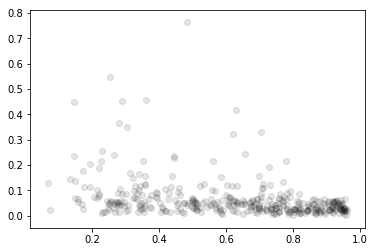

leftShoulder


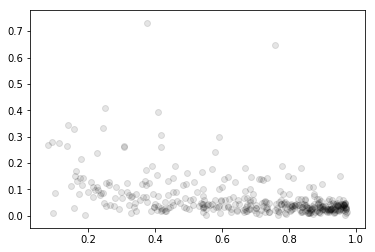

rightShoulder


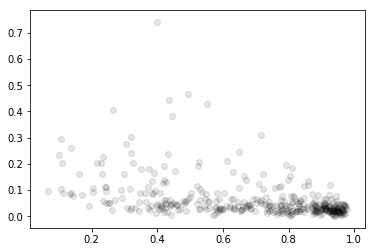

leftElbow


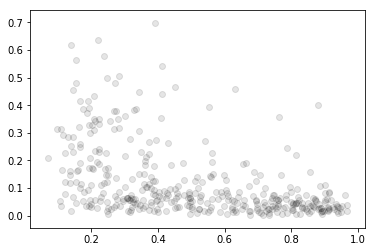

rightElbow


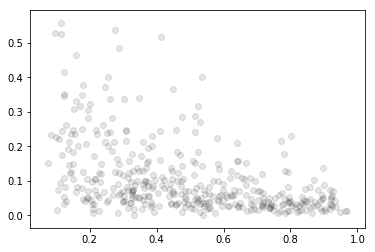

leftWrist


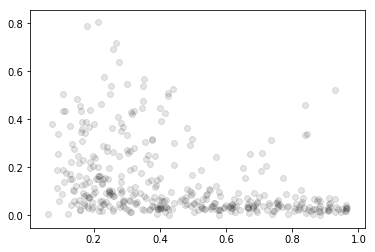

rightWrist


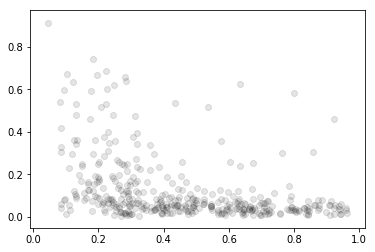

leftHip


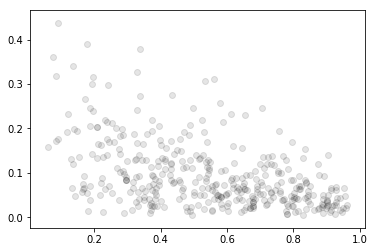

rightHip


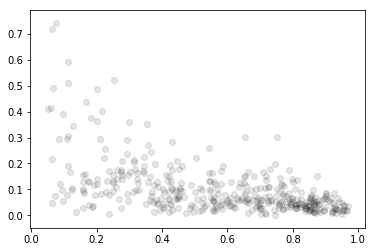

leftKnee


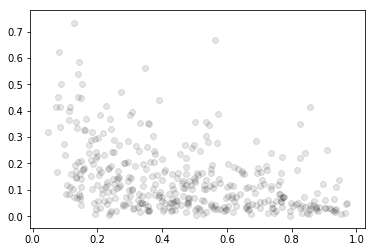

rightKnee


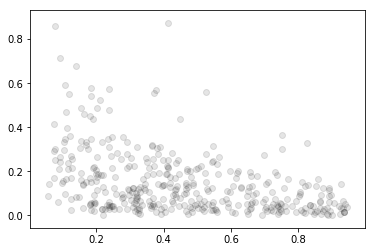

leftAnkle


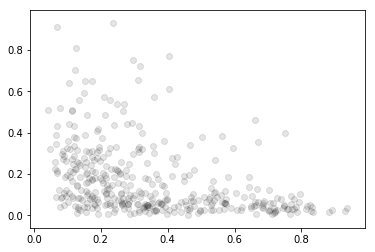

rightAnkle


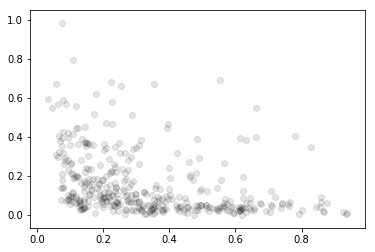

In [59]:
for i in range(13):
    print(PoseConfig.NAMES[i])
    viz(i,12)